In [1]:
from elasticsearch import Elasticsearch
import yaml
from yaml.loader import SafeLoader
import time
import json
import pandas as pd
from datetime import datetime, timedelta
import pytz
from datetime import timedelta
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



2023-03-23 20:02:22.412028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 20:02:22.412052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [75]:
### Configuration of the prediction
imput_width=24*7
label_width = 24


In [50]:
from binance.client import Client
import os 
from dotenv import load_dotenv


load_dotenv()

API_KEY =  os.getenv("API_KEY") 
API_SECRET =  os.getenv("API_SECRET") 

client = Client(API_KEY, API_SECRET )


def get_timestamp(date_str):
        date_obj = datetime.strptime(date_str, "%d %b %Y")
        timestamp_int = int(date_obj.timestamp())
        return timestamp_int




  
def get_binance_data ( coin,interval ,start , end):

        from binance.client import Client
        client = Client(API_KEY, API_SECRET)

        data = client.get_historical_klines( symbol = coin , interval=interval ,start_str =start, end_str =end)
    
        return data
start_time = "1 Jun 2018"

# Get current date and time
now = datetime.datetime.now()

# Format date and time as a string
end_time = now.strftime("%Y-%m-%d %H:%M:%S")


data = get_binance_data ('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, start_time, end_time )
len(data)

KeyboardInterrupt: 

In [54]:
import pandas as pd
df = pd.DataFrame(data , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)
df = df.astype(float)
df.drop( ["ignore"] , axis=1  , inplace=True)
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,,
1970-01-01 00:25:27.811200,7485.01,7538.00,7477.50,7517.84,1381.859204,1.527815e+12,1.037592e+07,8465.0,859.825064,6.456825e+06
1970-01-01 00:25:27.814800,7515.03,7515.04,7478.43,7483.99,845.777769,1.527818e+12,6.341206e+06,14282.0,492.022255,3.688720e+06
1970-01-01 00:25:27.818400,7483.99,7522.54,7480.00,7487.82,954.614574,1.527822e+12,7.162305e+06,12365.0,587.432232,4.407405e+06
1970-01-01 00:25:27.822000,7487.82,7509.99,7454.35,7495.13,978.126602,1.527826e+12,7.322881e+06,11082.0,537.670795,4.025818e+06
1970-01-01 00:25:27.825600,7495.13,7497.07,7455.48,7491.22,962.828704,1.527829e+12,7.202737e+06,14969.0,538.148326,4.026065e+06


In [38]:

def windorize ( data ):
    p95 = np.percentile(data, 80)
    p5 = np.percentile(data, 80)
    return np.clip(data, p5, p95)
windorize(df["volume"]).describe()

extreme_values=["volume" ,"quote_asset_volume" , "num_trades" , "taker_base_vol" , "taker_quote_vol"]


In [39]:
for value in extreme_values:
    df[value] = windorize(df[value] )

In [55]:
for value in df.columns:
    rolling_mean = df[value].shift(imput_width).rolling(window=30).mean()
    rolling_std = df[value].shift(imput_width).rolling(window=30).std()
    df[value] = (df[value] - rolling_mean) / rolling_std


In [57]:
df.dropna(axis = 0 , inplace=True)

In [58]:
df

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,,
1970-01-01 00:25:28.520400,3.409561,2.982280,3.750051,3.325346,-1.127545,20.730607,-1.080101,-1.779899,-1.433680,-1.383896
1970-01-01 00:25:28.524000,3.336921,2.772106,3.896646,3.093386,-1.902294,20.730607,-1.869189,-1.797608,-2.032300,-1.993307
1970-01-01 00:25:28.527600,3.097033,2.236600,3.006688,2.395165,-2.298153,20.730607,-2.270593,-0.067895,-2.473720,-2.440471
1970-01-01 00:25:28.531200,2.446472,1.763033,2.216263,1.618339,-0.922661,20.730607,-0.878181,1.991967,-0.596875,-0.545796
1970-01-01 00:25:28.534800,1.633468,1.396372,1.891416,1.739813,-1.253745,20.730607,-1.215080,-1.387085,-1.338751,-1.296240
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:59.587200,17.039141,14.872044,17.722602,16.232834,-1.397937,20.730607,-1.282628,-2.216587,-1.396852,-1.284178
1970-01-01 00:27:59.590800,16.219390,14.365416,16.508595,15.668348,-1.437159,20.730607,-1.338541,-2.206720,-1.435777,-1.340329
1970-01-01 00:27:59.594400,15.652459,14.899128,14.611164,14.072133,-1.359796,20.730607,-1.243627,-2.236104,-1.423570,-1.319075


In [59]:
# Class used for generating windows in the time serie  where inputs are used to produce the future outputs

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window
def plot(self,plot_col,  model=None,   max_subplots=3, ):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      try:
        predictions = model(inputs)
        print(predictions , len(predictions ))
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
         marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64) 
      except:
        #inputs = inputs[n:n+1]
        predictions = model.predict(inputs)
        plt.scatter(self.label_indices, predictions[0, :, 0],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
      

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds
def plot_data(df) :

    plot_cols = df.columns[1]
    plot_features = df[plot_cols]
    plot_features.index = df.index
    #_ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:480]
    plot_features.index = df.index[:480]
    _ = plot_features.plot(subplots=True)

WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
count,2.931600e+04,2.931600e+04,2.931600e+04,29316.000000,2.931600e+04,2.931600e+04,2.931600e+04,2.931600e+04,2.931600e+04,2.931600e+04
mean,-2.520686e-17,-5.816969e-18,7.755958e-18,0.000000,2.035939e-17,4.544507e-16,-3.877979e-18,1.745091e-17,-1.502717e-17,-2.423737e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.247188e+01,-1.147129e+01,-1.049009e+01,-12.607698,-1.529439e+00,-1.508451e+01,-1.589133e+00,-1.852416e+00,-1.592971e+00,-1.642319e+00
25%,-3.425406e-01,-3.468422e-01,-3.461184e-01,-0.341696,-4.298809e-01,-1.668136e-02,-4.610259e-01,-4.841100e-01,-4.440016e-01,-4.705693e-01
50%,-7.108022e-02,-7.623657e-02,-6.320049e-02,-0.071057,-2.495849e-01,-1.668136e-02,-2.672406e-01,-2.524491e-01,-2.506932e-01,-2.676135e-01
75%,2.828357e-01,2.778926e-01,2.941862e-01,0.281971,9.289562e-02,-1.668136e-02,1.107997e-01,1.561660e-01,1.043642e-01,1.192483e-01
max,9.501630e+00,1.013506e+01,9.863735e+00,9.573227,2.933292e+01,2.752507e+00,2.088776e+01,2.330133e+01,2.446741e+01,1.753205e+01


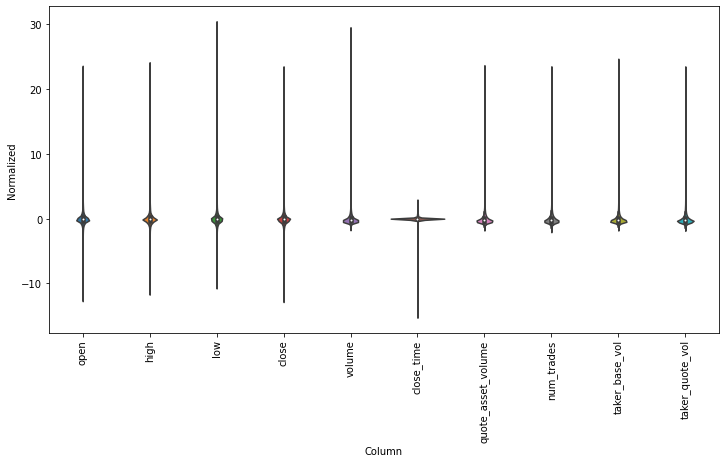

In [65]:

import numpy as np

def train_test(df):
    

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    df_std = (df - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(df.keys(), rotation=90)
    return train_df , val_df , test_df



test = train_test(df)[0]

def compile_and_fit(model, window, patience=2):
  MAX_EPOCHS = 20

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history
test.describe()

In [61]:
df.describe()

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
count,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000
mean,1.444381,1.425230,1.408129,1.443281,0.333744,20.735876,0.346280,0.342009,0.319761,0.331377
std,17.574148,17.229821,17.293325,17.590660,2.365384,0.377528,2.267502,2.211759,2.276931,2.209267
min,-204.206451,-188.062915,-159.173092,-206.880625,-3.537065,13.931688,-3.413388,-3.949557,-3.496084,-3.441360
25%,-4.151866,-4.194359,-3.933994,-4.150763,-0.734684,20.730607,-0.732067,-0.766968,-0.737964,-0.737603
50%,0.440970,0.360483,0.504483,0.441034,-0.272509,20.730607,-0.264180,-0.225523,-0.267073,-0.264538
75%,5.817907,5.809910,5.685984,5.813438,0.611173,20.730607,0.642958,0.727131,0.608765,0.635127
max,388.260234,398.318544,466.082784,387.618326,73.805924,21.980123,56.181393,54.468408,59.038417,54.118235


In [69]:
#variables_used = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol' ]
variables_used = ['close']

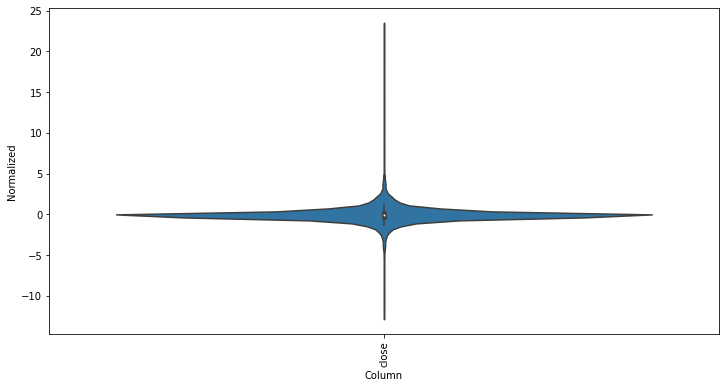

In [79]:
train_df, val_df, test_df = train_test(df[variables_used])

wide_window = WindowGenerator(
        input_width=imput_width, label_width=label_width, shift=0,
        label_columns=["close"] , train_df=train_df, val_df=val_df, test_df=test_df )

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(imput_width, len(variables_used))),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(label_width)
])

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, -48:-24, self.label_index]
    return result[:, :, tf.newaxis]

column_indices = {name: i for i, name in enumerate(df.columns)}

baseline = Baseline(label_index=column_indices['close'])
LSTM =  tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(imput_width,  len(variables_used))),
    tf.keras.layers.Dense(label_width)
])

Conv1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(imput_width,  len(variables_used))),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(label_width)
])


models = [ 
  # baseline , 
 
  dense , LSTM , Conv1D]


In [80]:

val_performance={}
performance={}
for model in models:
        history = compile_and_fit(model, wide_window)

        val_performance[f"{model.name}"] = model.evaluate(wide_window.val)
        performance[f"{model.name}"] = model.evaluate(wide_window.test, verbose=0)


Epoch 1/20
911/911 [==============================] - 6s 7ms/step - loss: 0.0284 - mean_absolute_error: 0.0825 - val_loss: 0.0031 - val_mean_absolute_error: 0.0378
Epoch 2/20
911/911 [==============================] - 6s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0456 - val_loss: 0.0018 - val_mean_absolute_error: 0.0278
Epoch 3/20
911/911 [==============================] - 7s 8ms/step - loss: 0.0051 - mean_absolute_error: 0.0392 - val_loss: 0.0016 - val_mean_absolute_error: 0.0259
Epoch 4/20
911/911 [==============================] - 6s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0352 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 5/20
911/911 [==============================] - 6s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0335 - val_loss: 0.0012 - val_mean_absolute_error: 0.0229
Epoch 6/20
911/911 [==============================] - 6s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0305 - val_loss: 7.5650e-04 - val_mean_absolute_error: 0.0182
Epoch 7/20
9

In [82]:
performance


{'sequential_15': [0.00447112089022994, 0.02865179069340229],
 'sequential_16': [1.3842569589614868, 0.18737848103046417],
 'sequential_17': [0.15527217090129852, 0.17196621000766754]}

In [93]:
data_pred = get_binance_data('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, '1 Mar 2023', '24 Mar 2023')
df_pred = pd.DataFrame(data_pred , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df_pred['open_time'] = pd.to_datetime(df_pred['open_time'])
df_pred.set_index('open_time', inplace=True)
df_pred = df_pred.astype(float)
df_pred.head()


,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
open_time,,,,,,,,,,,
1970-01-01 00:27:57.628800,23141.57,23219.99,23020.03,23101.00,12736.94918,1.677632e+12,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0
1970-01-01 00:27:57.632400,23101.00,23296.94,23075.14,23245.96,11574.17720,1.677636e+12,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0
1970-01-01 00:27:57.636000,23245.96,23336.46,23234.20,23331.21,7905.82139,1.677640e+12,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0
1970-01-01 00:27:57.639600,23332.57,23498.00,23305.97,23441.14,14946.69431,1.677643e+12,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0
1970-01-01 00:27:57.643200,23440.37,23847.00,23425.44,23794.48,15445.26401,1.677647e+12,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0


In [97]:
df_pred

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
open_time,,,,,,,,,,,
1970-01-01 00:27:57.628800,23141.57,23219.99,23020.03,23101.00,12736.94918,1.677632e+12,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0
1970-01-01 00:27:57.632400,23101.00,23296.94,23075.14,23245.96,11574.17720,1.677636e+12,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0
1970-01-01 00:27:57.636000,23245.96,23336.46,23234.20,23331.21,7905.82139,1.677640e+12,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0
1970-01-01 00:27:57.639600,23332.57,23498.00,23305.97,23441.14,14946.69431,1.677643e+12,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0
1970-01-01 00:27:57.643200,23440.37,23847.00,23425.44,23794.48,15445.26401,1.677647e+12,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:59.601600,28369.82,28371.92,28096.60,28280.03,4652.98435,1.679605e+12,1.312611e+08,81447.0,2397.54537,6.763083e+07,0.0
1970-01-01 00:27:59.605200,28280.03,28280.03,27967.93,28163.79,2840.11442,1.679609e+12,7.989510e+07,72984.0,1293.26133,3.637930e+07,0.0
1970-01-01 00:27:59.608800,28163.80,28265.17,28087.93,28214.10,2872.38103,1.679612e+12,8.093029e+07,45114.0,1541.77574,4.344221e+07,0.0


In [98]:
    def normalize(df):
        df_back = df.drop("ingore" , axis=1)
       """  for value in df.columns:
            rolling_mean = df_back[value].shift(imput_width).rolling(window=30).mean()
            rolling_std = df_back[value].shift(imput_width).rolling(window=30).std()
            df[value] = (df_back[value] - rolling_mean) / rolling_std
 """
       
        
        

        train_mean = train_df.mean()
        train_std = train_df.std()

        return   (df_back - train_mean) / train_std

      


In [96]:
df_pred_norm = normalize(df_pred.drop("ignore",axis=1))
df_pred_norm

,close,close_time,high,low,num_trades,open,quote_asset_volume,taker_base_vol,taker_quote_vol,volume
open_time,,,,,,,,,,
1970-01-01 00:27:57.628800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:57.632400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:57.636000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:57.639600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:57.643200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:59.601600,15.115283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:59.605200,14.080010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 00:27:59.608800,14.325229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


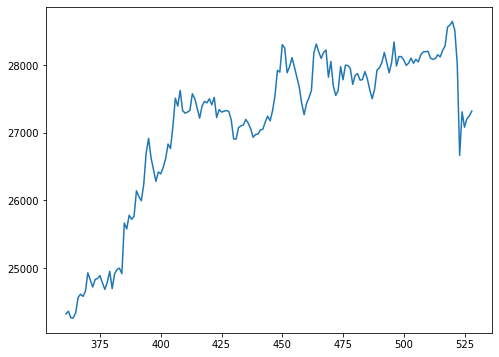

In [145]:
import matplotlib.pyplot as plt

plt.plot(df_pred["close"].tail(imput_width))
# display the plot
plt.show()

In [135]:
 
def data_for_prediction_parser( df):
  data = np.array(df [variables_used].tail(imput_width), dtype=np.float32)
  print(  data)
  return data .reshape((1, imput_width, len( variables_used)))


In [146]:
data_for_prediction = data_for_prediction_parser(df_pred_norm)

[[0.45350522]
 [0.45597076]
 [0.44999978]
 [0.449829  ]
 [0.45475212]
 [0.46863022]
 [0.47142684]
 [0.4693894 ]
 [0.4741258 ]
 [0.4908343 ]
 [0.48434734]
 [0.47793224]
 [0.48480618]
 [0.4856999 ]
 [0.48826742]
 [0.48165515]
 [0.47577012]
 [0.48226815]
 [0.49224582]
 [0.47650045]
 [0.489838  ]
 [0.49398905]
 [0.49504492]
 [0.49009168]
 [0.5360643 ]
 [0.53075546]
 [0.54313236]
 [0.5394703 ]
 [0.54216313]
 [0.5652744 ]
 [0.5601339 ]
 [0.5563231 ]
 [0.5712952 ]
 [0.59995246]
 [0.61297554]
 [0.5953598 ]
 [0.5844233 ]
 [0.57392657]
 [0.5824239 ]
 [0.5807434 ]
 [0.5865056 ]
 [0.5944772 ]
 [0.60782456]
 [0.6038148 ]
 [0.6237579 ]
 [0.6494969 ]
 [0.64223784]
 [0.6565115 ]
 [0.63822377]
 [0.63584054]
 [0.63685775]
 [0.6383135 ]
 [0.6534735 ]
 [0.6490037 ]
 [0.64007324]
 [0.63133144]
 [0.64243007]
 [0.6465412 ]
 [0.64518374]
 [0.648879  ]
 [0.643454  ]
 [0.65024936]
 [0.63186336]
 [0.639096  ]
 [0.63682884]
 [0.63760465]
 [0.63822687]
 [0.6374978 ]
 [0.62962997]
 [0.61246693]
 [0.61228514]
 [0.62

In [260]:
std = train_df.std()["close"]
mean = train_df["close"].mean()
std , mean

(1.0, 3.8783760693759096e-18)

In [151]:
test_df.tail()["close"]

open_time
1970-01-01 00:27:59.500800    28647.26
1970-01-01 00:27:59.504400    28516.34
1970-01-01 00:27:59.508000    28027.99
1970-01-01 00:27:59.511600    26667.33
1970-01-01 00:27:59.515200    27311.29
Name: close, dtype: float64

In [ ]:


df_pred_norm = (df_pred - train_mean) / train_std

1/1 [==============================] - 0s 76ms/step


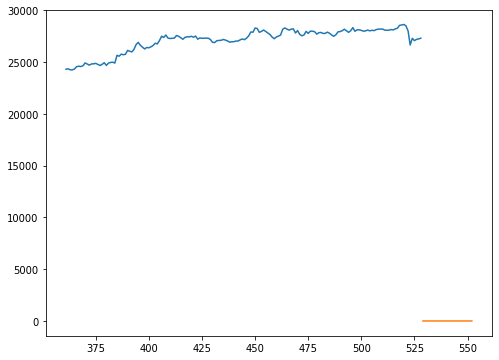

In [143]:

prediction = models[0].predict(data_for_prediction)[0]
normalized_prediction = pd.DataFrame(prediction, columns=["predictions"] ) 
predictions = pd.DataFrame( (std*(normalized_prediction)) + mean)

df_pred.reset_index(inplace=True , drop=True) 
predictions.set_index( np.arange( df_pred.shape[0] , np.array( df_pred.shape[0]+ 24 )) ,inplace=True)
plt.plot(df_pred["close"].tail(imput_width))
# display the plot
plt.plot( predictions )



plt.show()